### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/18_adjusting_inertia/alabama/2023_07_19_11_11_52/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/18_adjusting_inertia/alabama/2023_07_19_11_11_52/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.loc[person_time.scenario == 'baseline']
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw']).ptvalue.sum().reset_index()
per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,Female,2023,29,1833.089665
1,25_to_29,Female,2023,232,1769.308693
2,25_to_29,Female,2023,357,1779.887748
3,25_to_29,Female,2023,394,1746.694045
4,25_to_29,Female,2023,602,1774.904860


In [5]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,56144.628677
1,1,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,53867.925388
2,2,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,52417.114970
3,3,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,53393.417303
4,4,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,54338.527712


### LDL-C

In [6]:
ldl_exp = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,2.634020,2.566820,2.799067
1,25_to_29,Female,2024,2.632969,2.562106,2.796060
2,25_to_29,Female,2025,2.636958,2.562909,2.785266
3,25_to_29,Female,2026,2.636483,2.549079,2.795712
4,25_to_29,Female,2027,2.636040,2.537074,2.800786


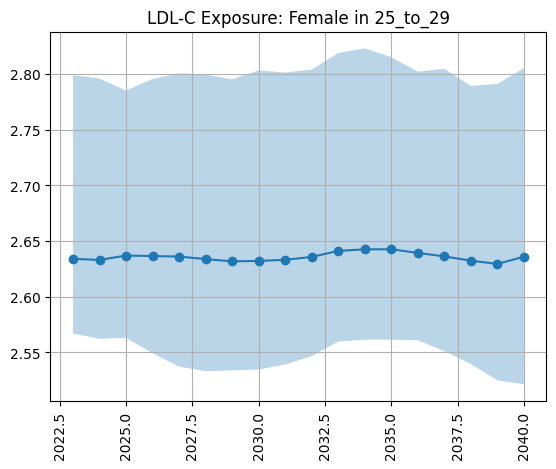

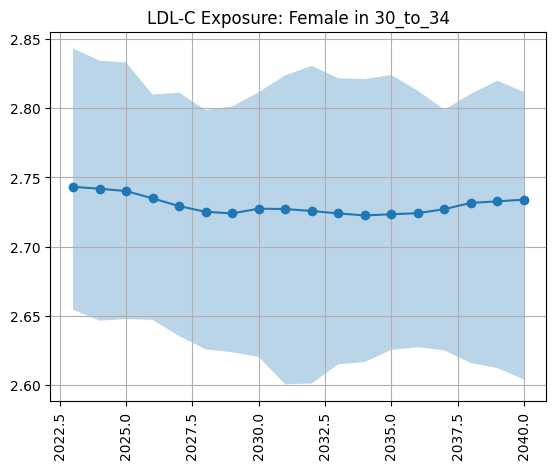

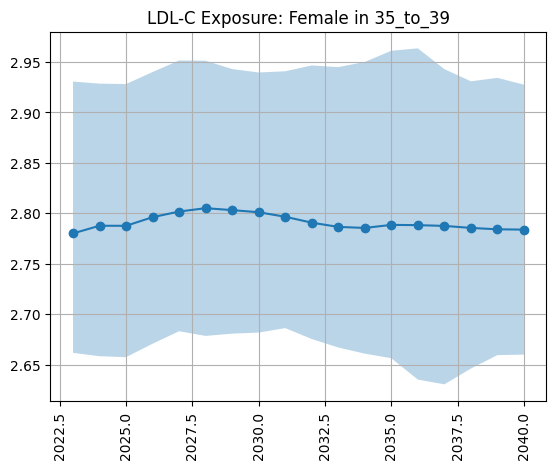

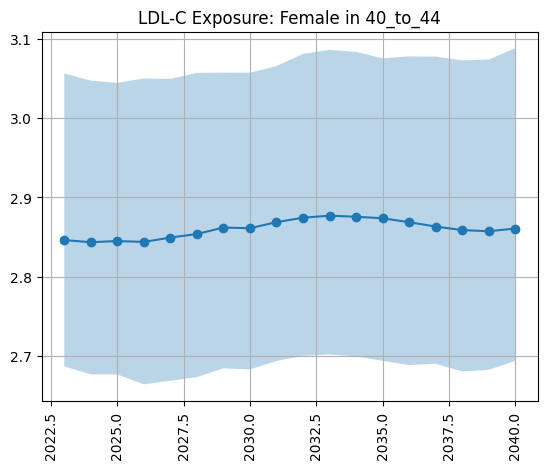

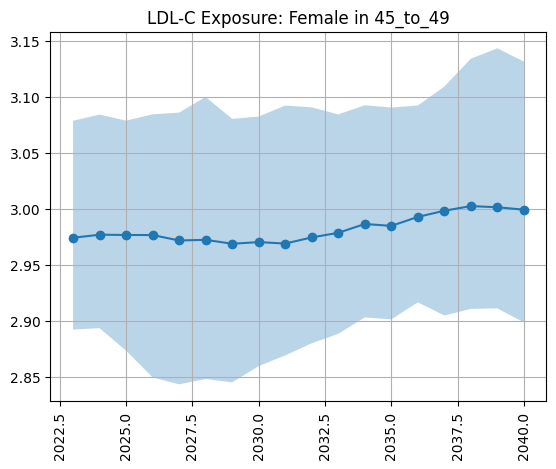

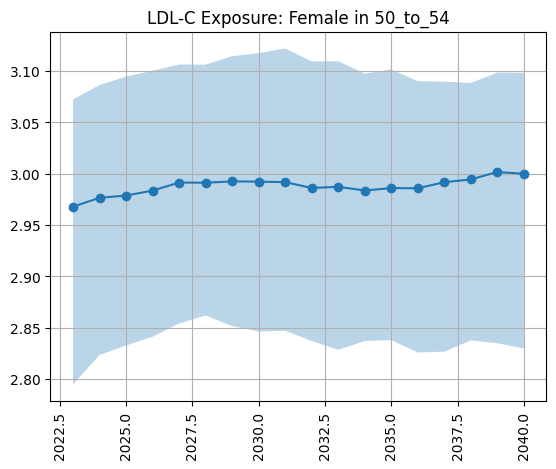

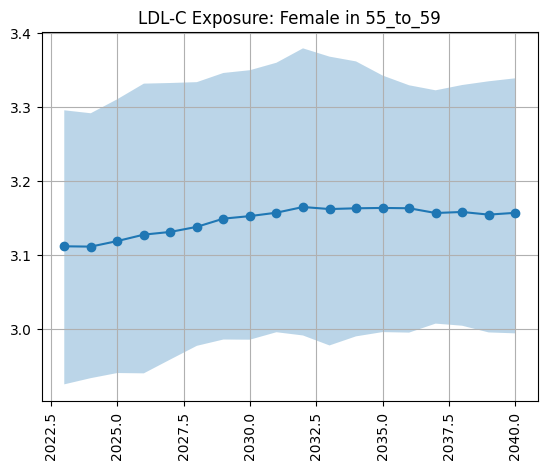

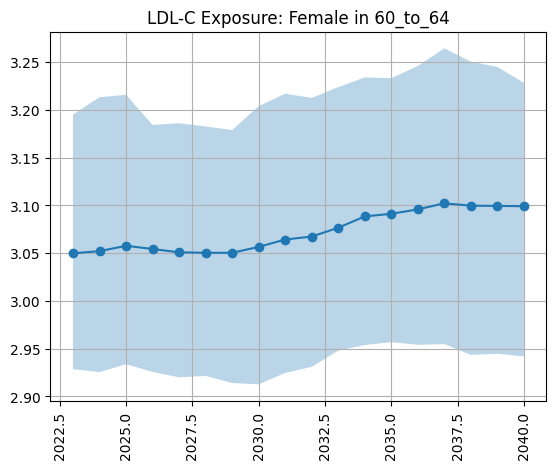

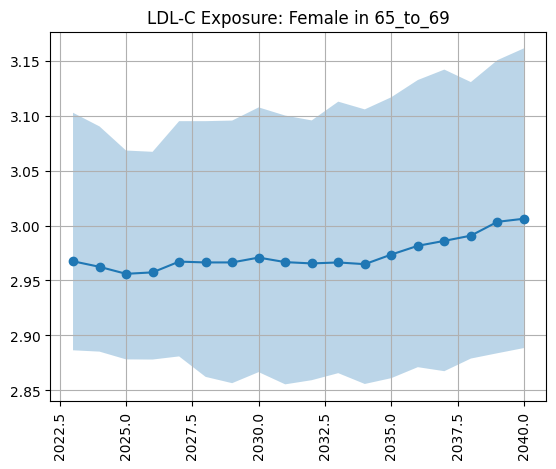

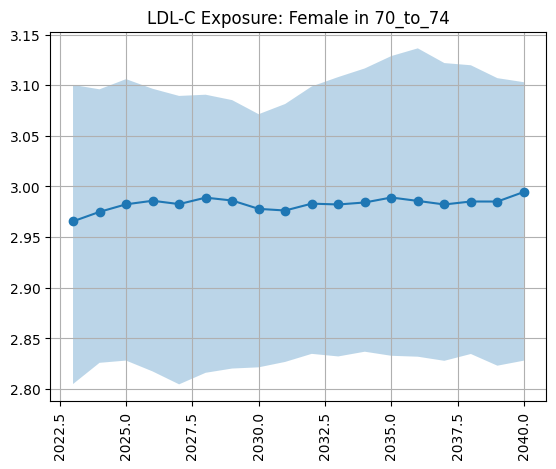

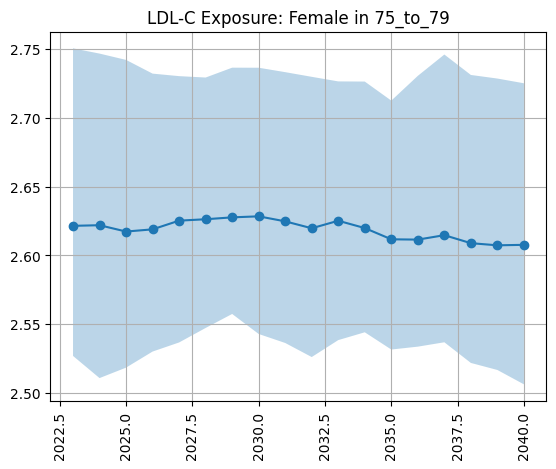

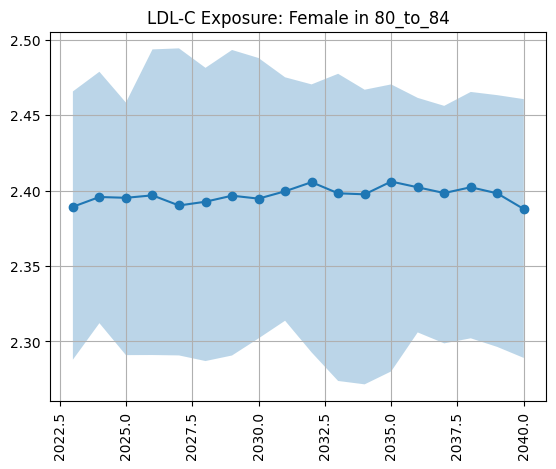

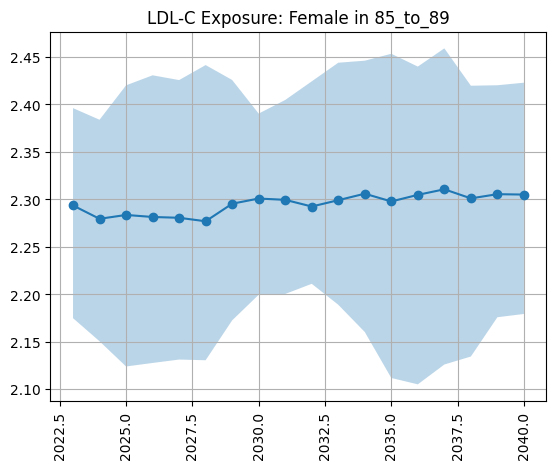

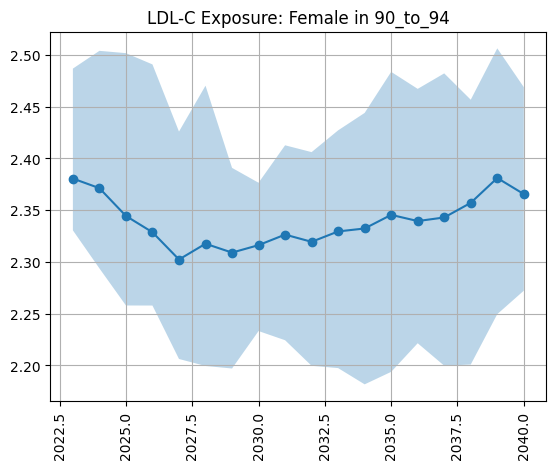

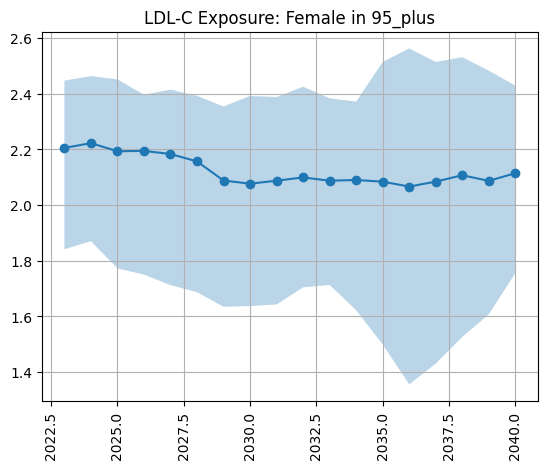

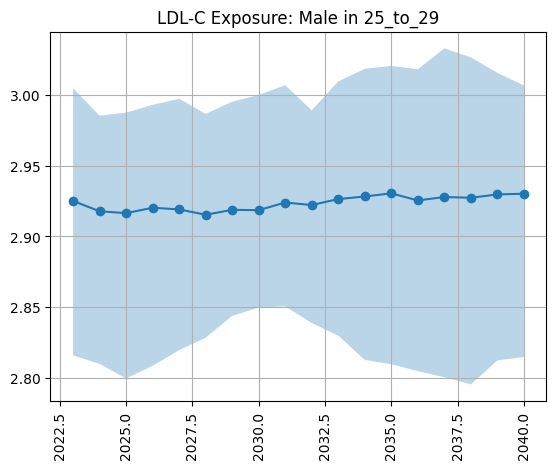

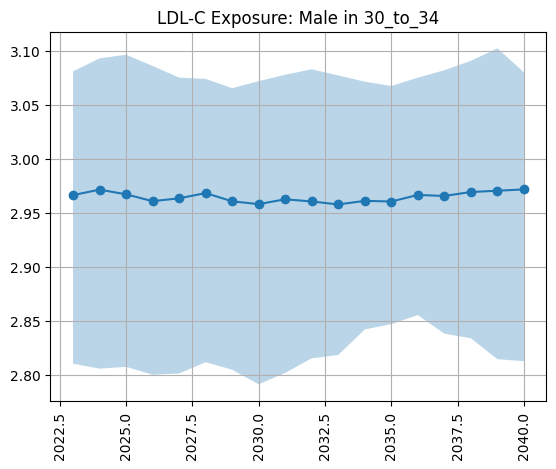

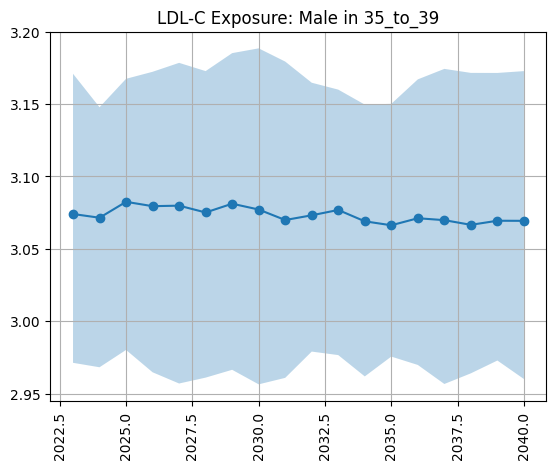

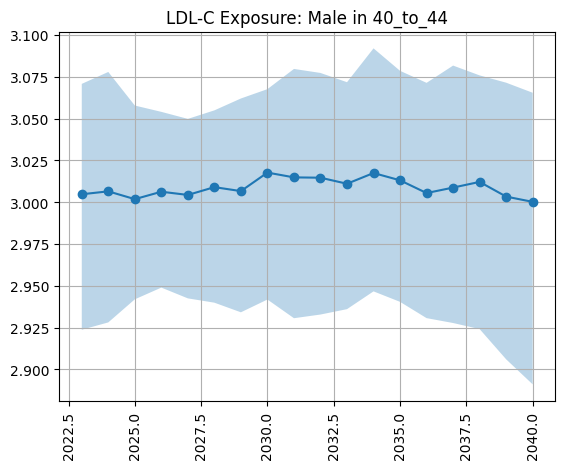

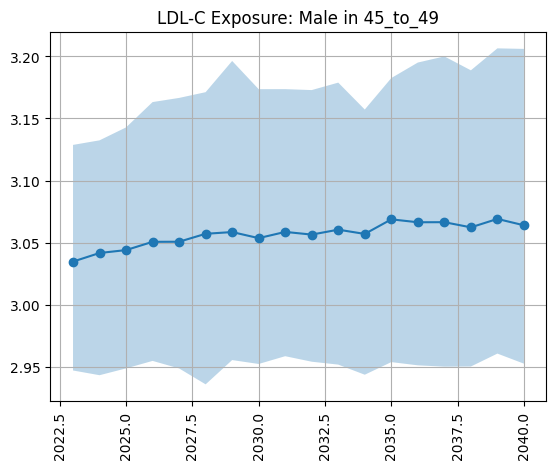

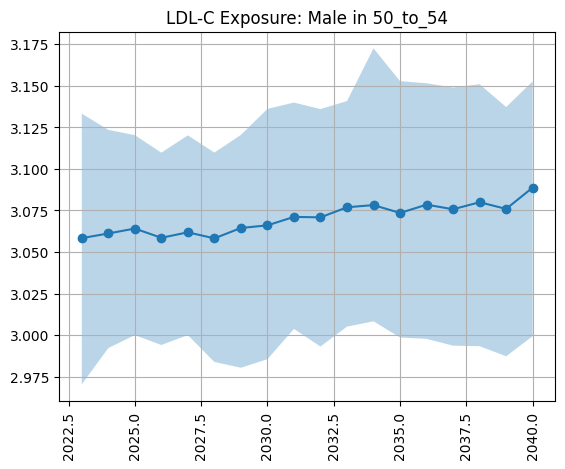

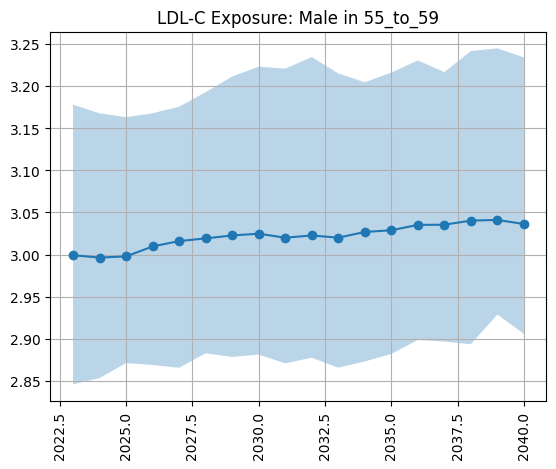

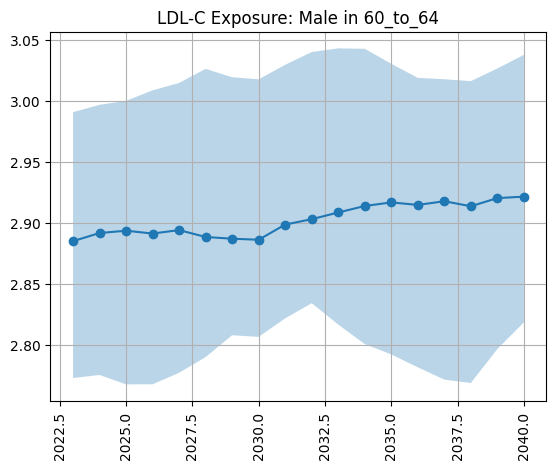

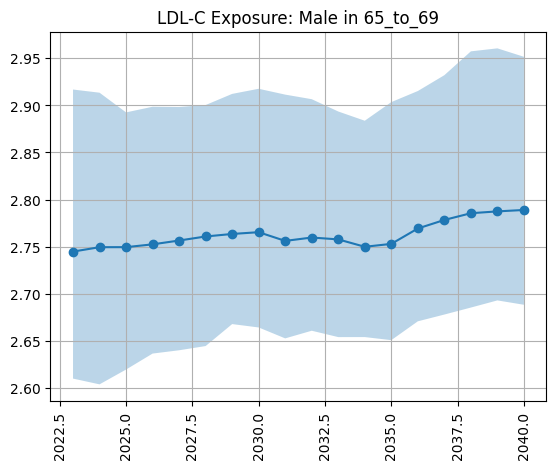

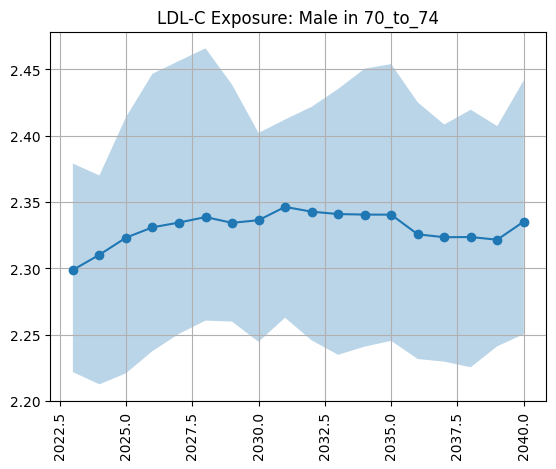

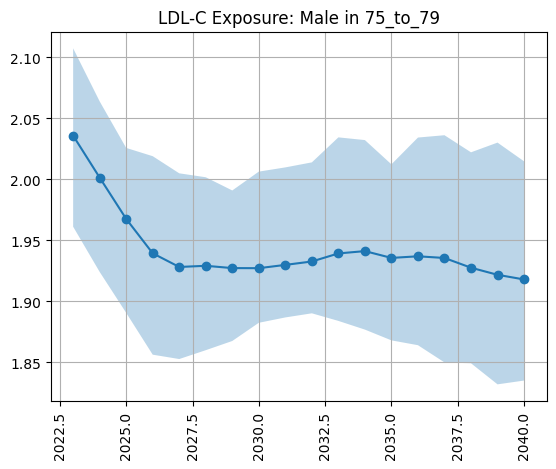

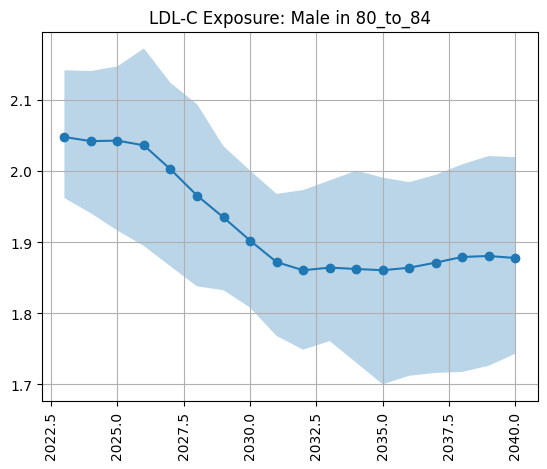

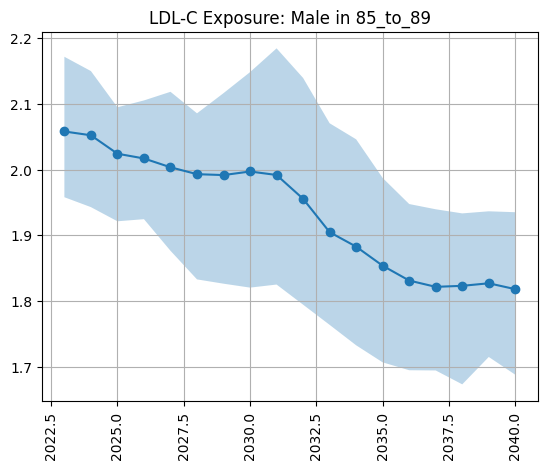

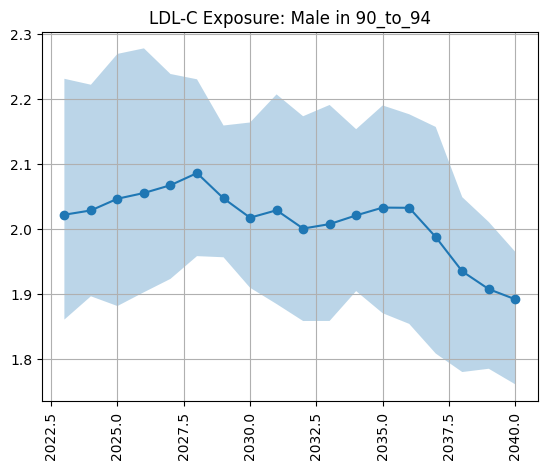

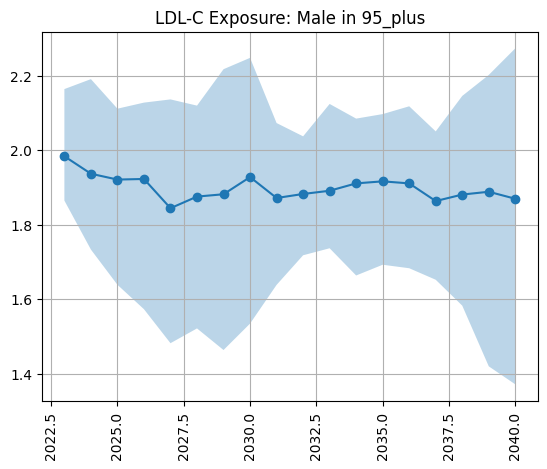

In [7]:
#%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL-C Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

## Comparison to Artifacts

In [8]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/

51-locations/                       north_dakota.hdf  washington.hdf
alabama.hdf                         raw_data/         west_virginia.hdf
alabama_before_calculated_pafs.hdf  rhode_island.hdf


In [9]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [10]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [11]:
#art.keys

In [12]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_946']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### LDL-C

In [13]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
#ldl_art.reset_index(inplace=True)
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,2.639862,2.638003,2.472574,2.821188,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,2.724353,2.723671,2.553736,2.905134,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,2.802925,2.801341,2.639513,2.972487,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,2.880791,2.878250,2.721814,3.039119,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,2.998297,2.995129,2.837974,3.175367,Alabama,exposure,45_to_49


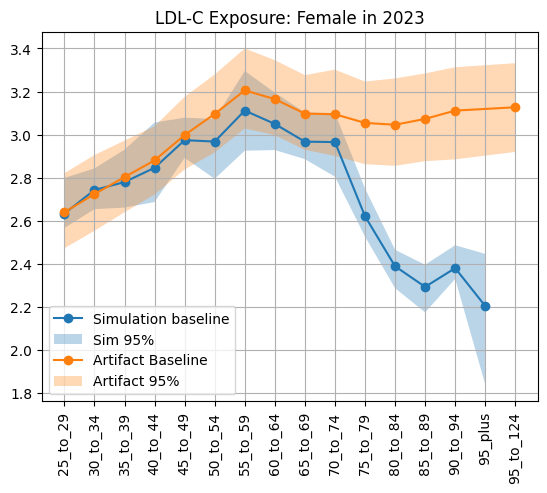

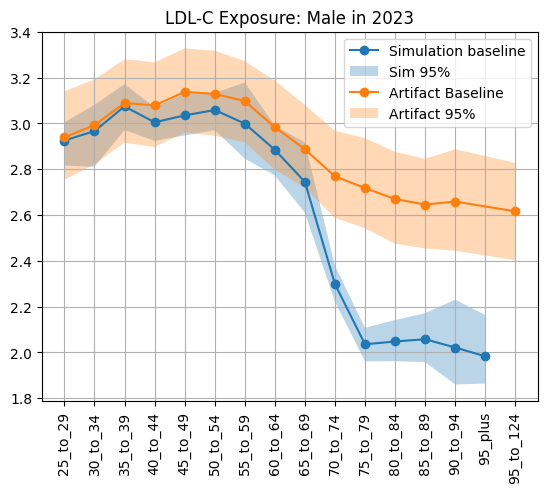

In [16]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Medication

In [17]:
meds = pd.read_csv(sim_results_dir + '/sbp_medication_person_time.csv')
meds.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,medication_adherence,sbp_medication,value
0,0,Female,2023,sbp_medication_person_time,29,baseline,25_to_29,primary_non_adherent,no_treatment,262.406571
1,1,Female,2023,sbp_medication_person_time,29,baseline,25_to_29,secondary_non_adherent,no_treatment,178.464066
2,2,Female,2023,sbp_medication_person_time,29,baseline,25_to_29,adherent,no_treatment,1247.485284
3,3,Female,2023,sbp_medication_person_time,29,baseline,30_to_34,primary_non_adherent,no_treatment,222.543463
4,4,Female,2023,sbp_medication_person_time,29,baseline,30_to_34,secondary_non_adherent,no_treatment,147.340178


In [23]:
meds_adherent = meds.loc[meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['sex', 'age', 'year', 'sbp_medication','scenario'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

,sex,age,year,sbp_medication,scenario,mean,2.5%,97.5%
0,Female,25_to_29,2023,no_treatment,baseline,0.666726,0.650606,0.682677
1,Female,25_to_29,2023,one_drug_half_dose_efficacy,baseline,0.045207,0.038304,0.057295
2,Female,25_to_29,2023,one_drug_std_dose_efficacy,baseline,0.001268,0.000060,0.003995
3,Female,25_to_29,2023,three_drug_half_dose_efficacy,baseline,0.000257,0.000000,0.000806
...,...,...,...,...,...,...,...,...
3776,Male,95_plus,2040,three_drug_half_dose_efficacy,baseline,0.030225,0.000000,0.097360
3777,Male,95_plus,2040,three_drug_std_dose_efficacy,baseline,0.160490,0.052506,0.256370
3778,Male,95_plus,2040,two_drug_half_dose_efficacy,baseline,0.094364,0.035116,0.144162
3779,Male,95_plus,2040,two_drug_std_dose_efficacy,baseline,0.037781,0.000000,0.100333


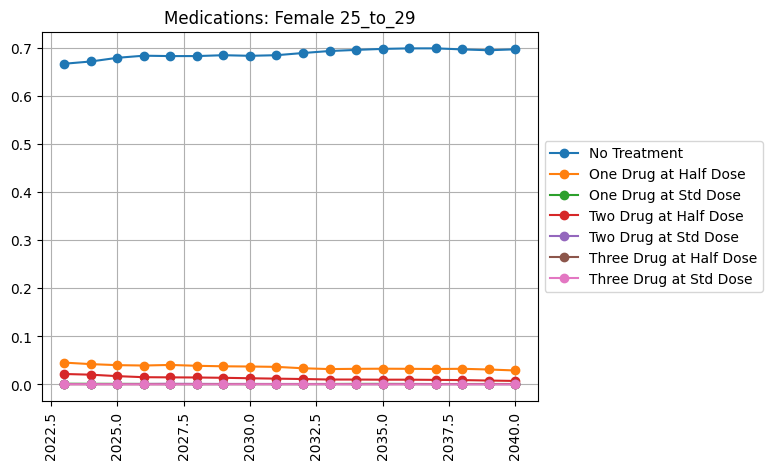

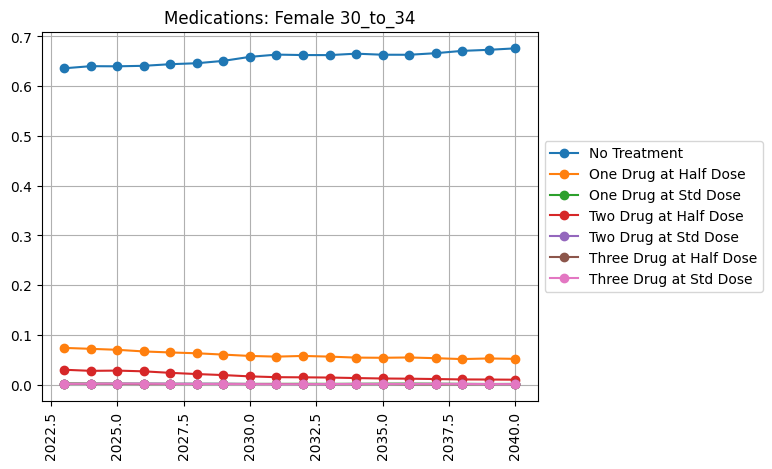

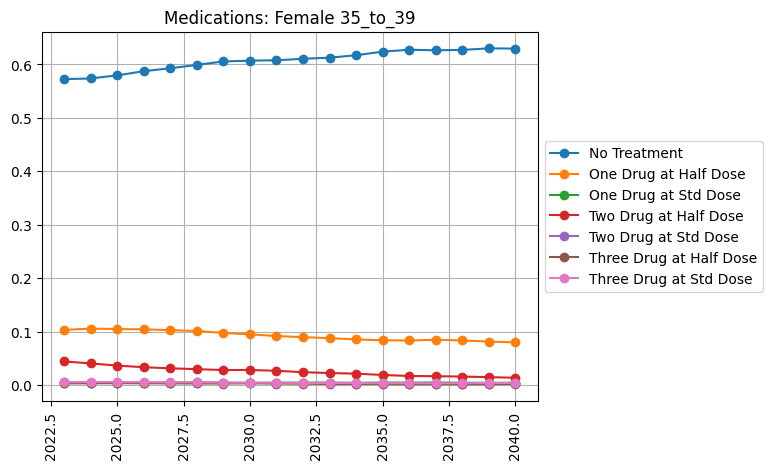

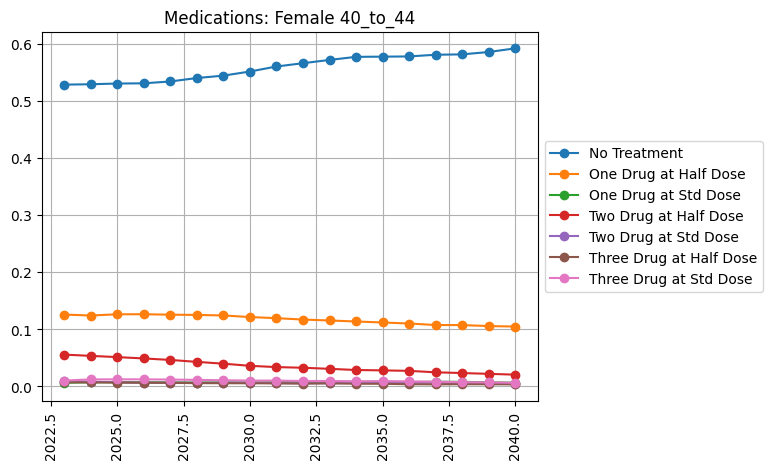

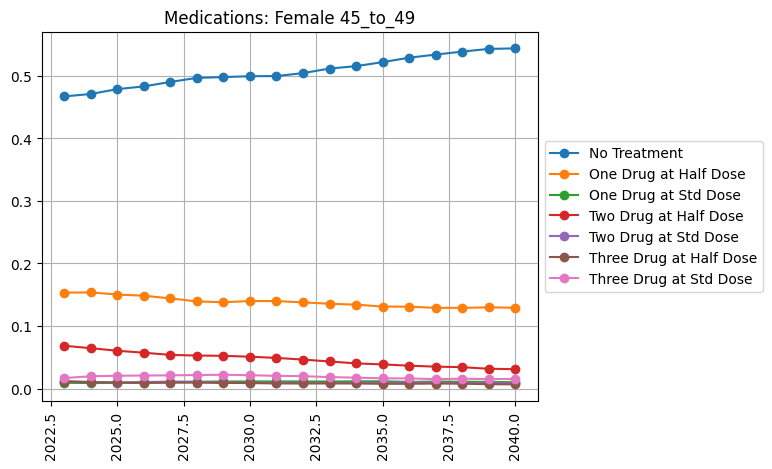

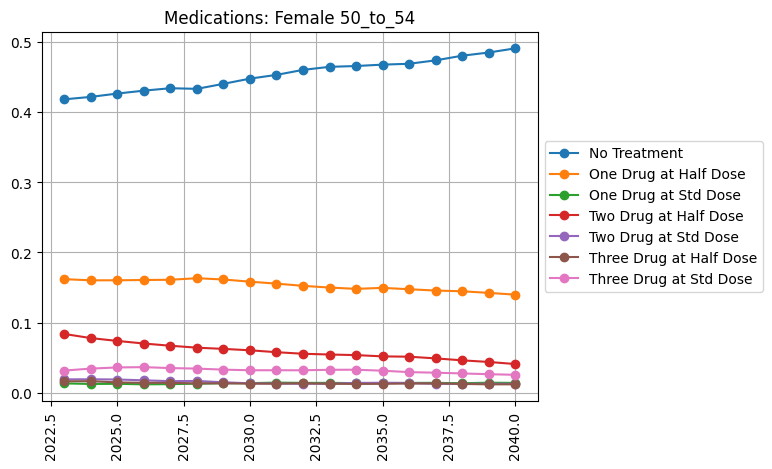

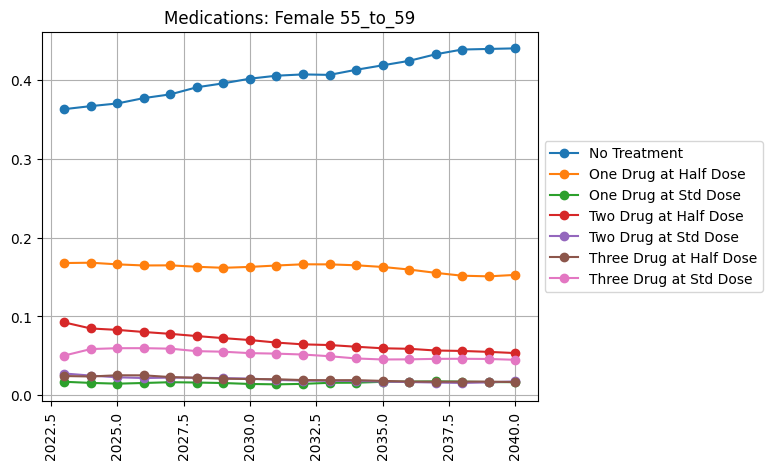

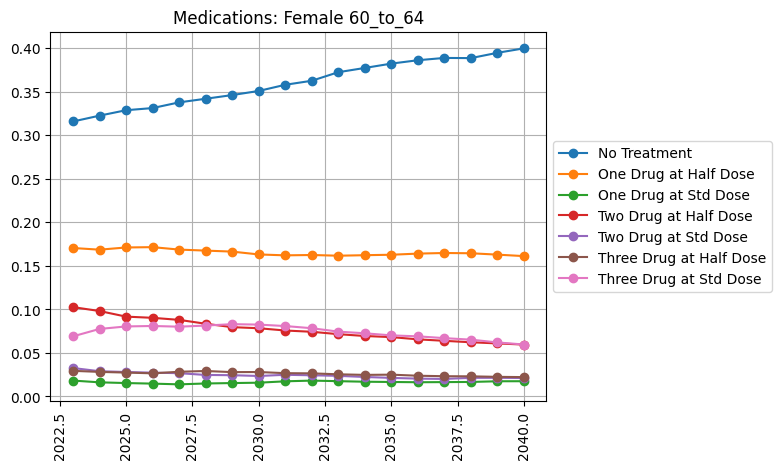

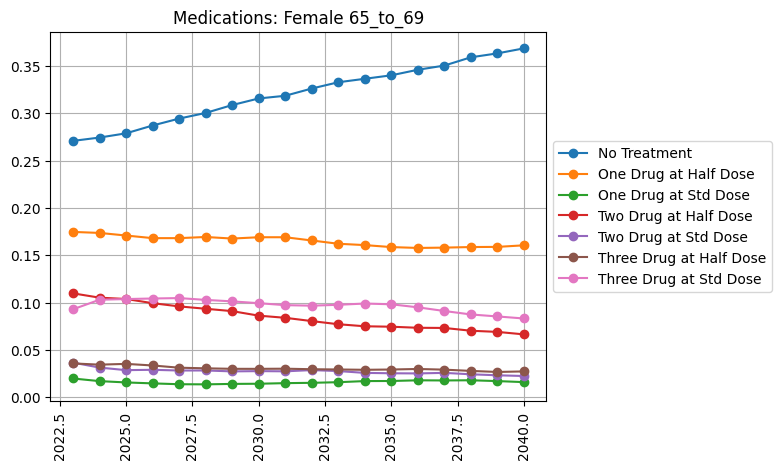

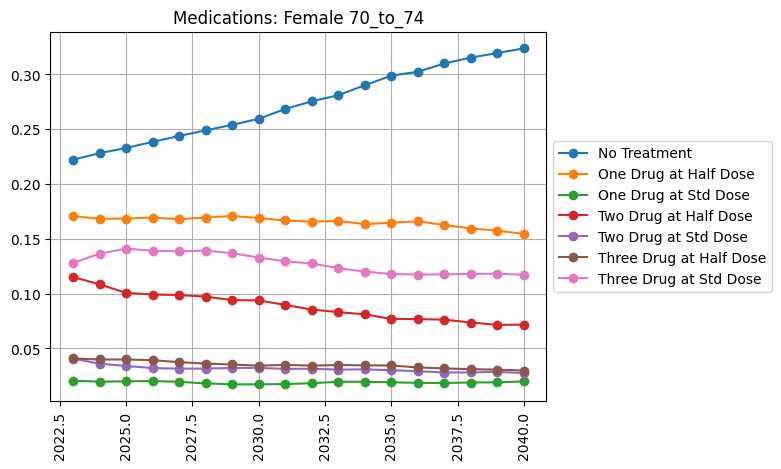

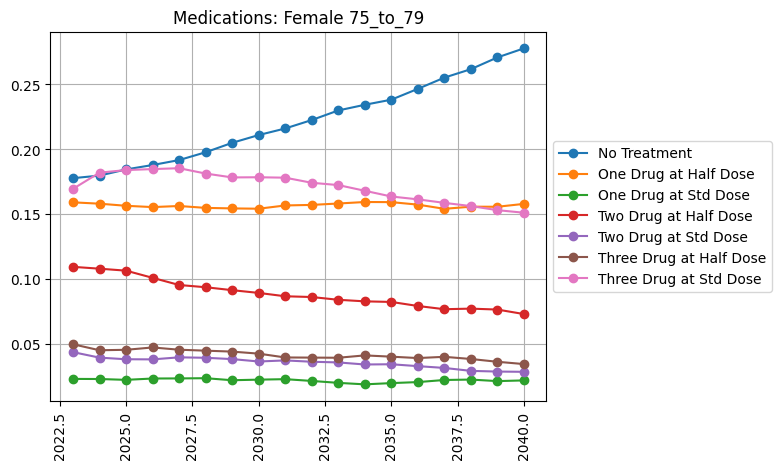

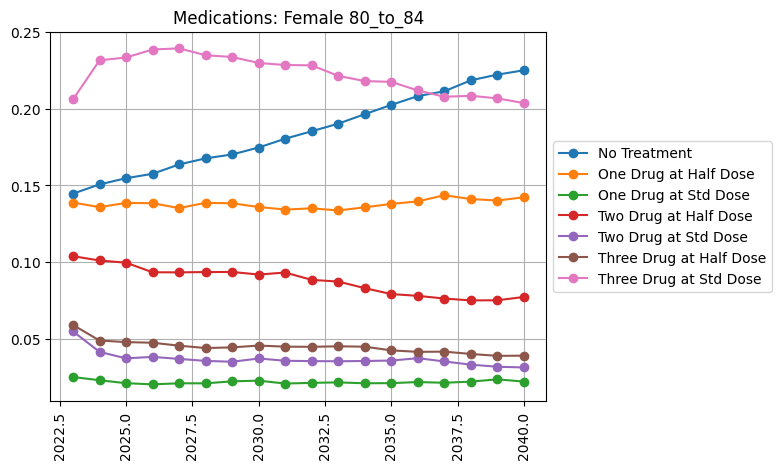

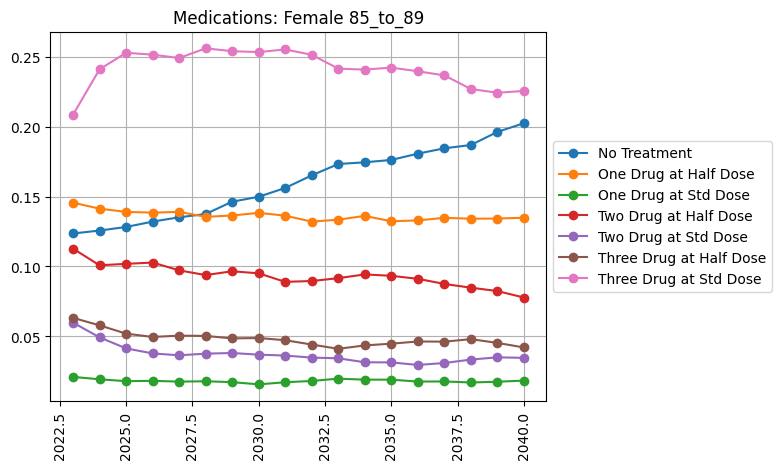

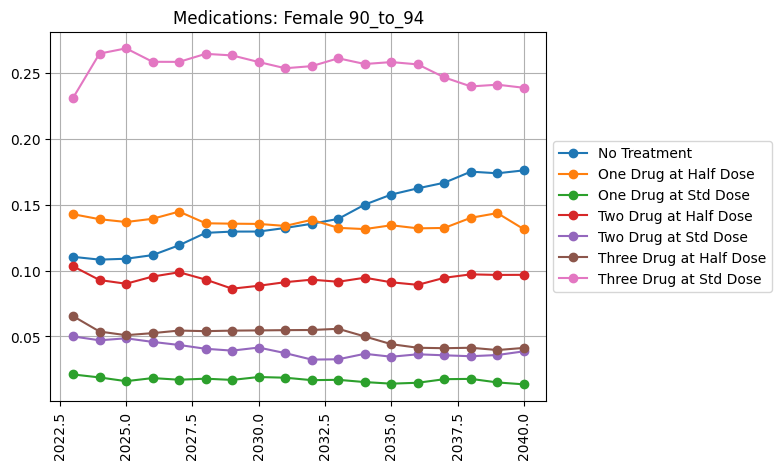

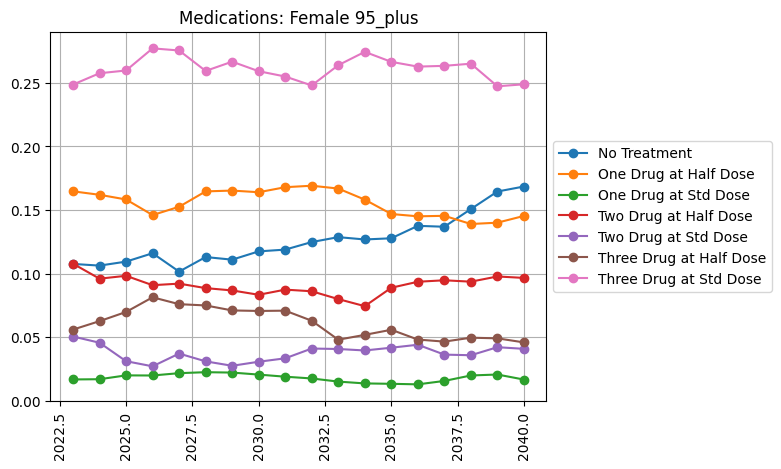

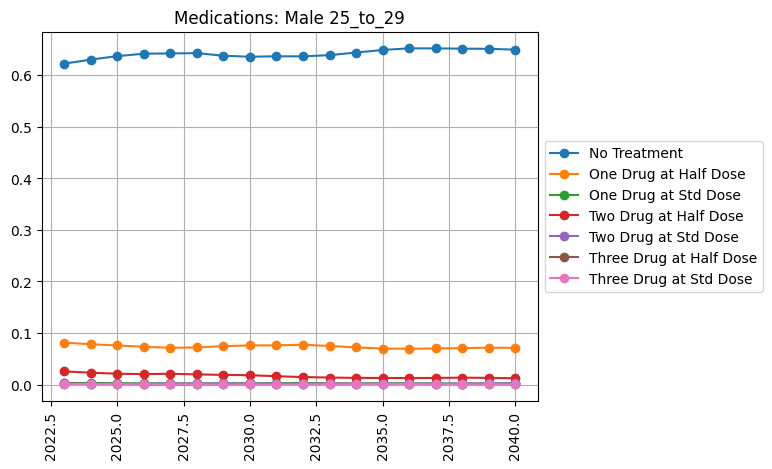

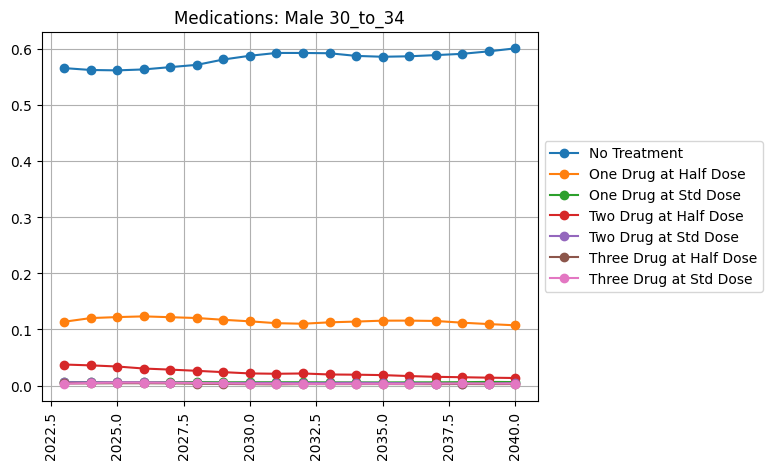

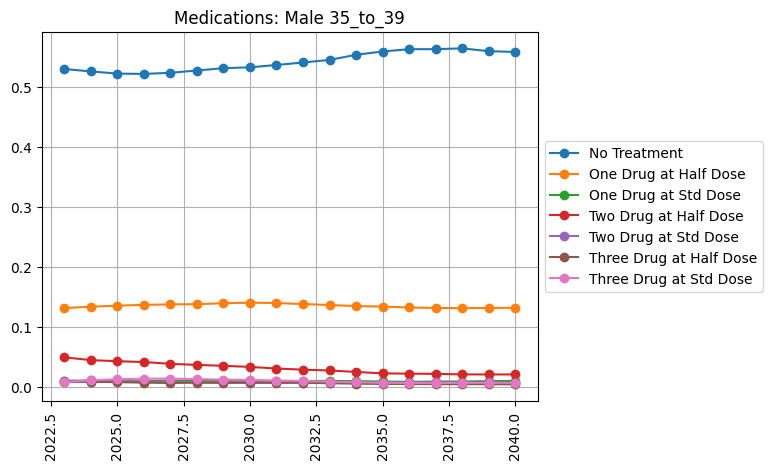

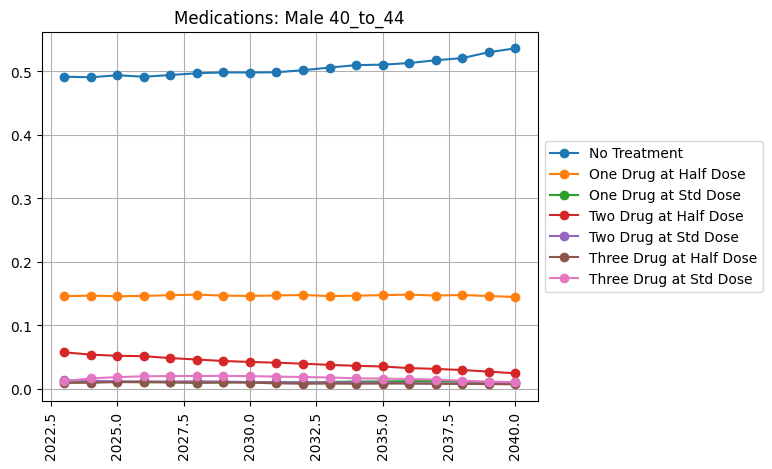

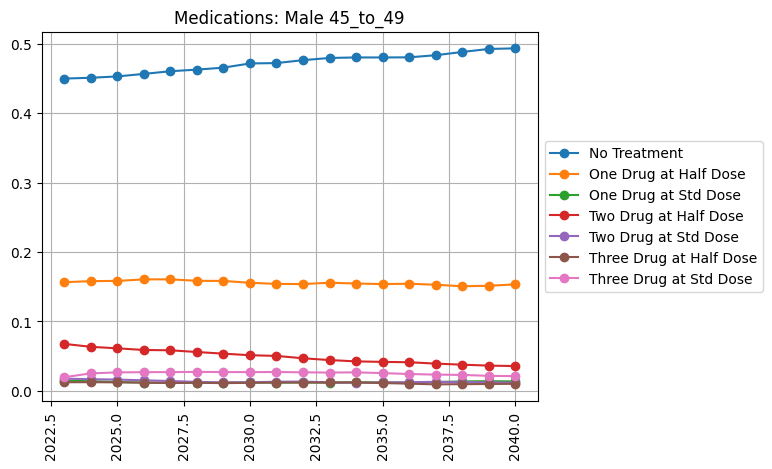

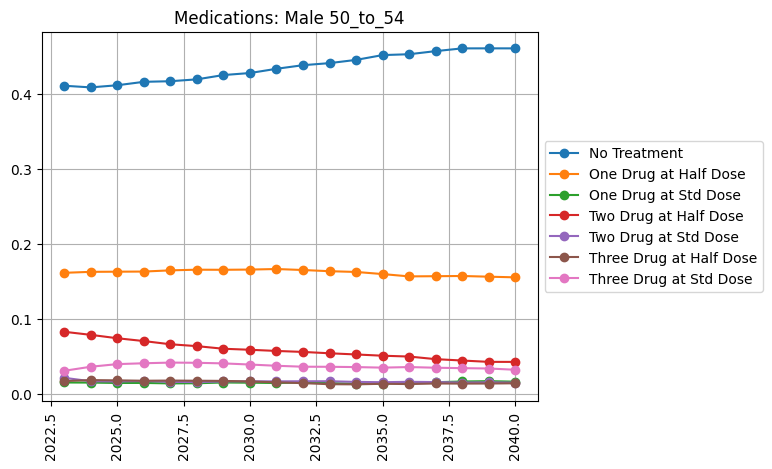

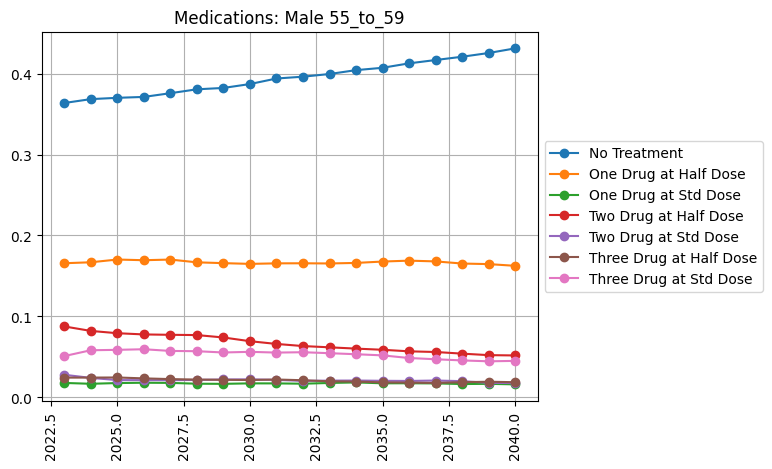

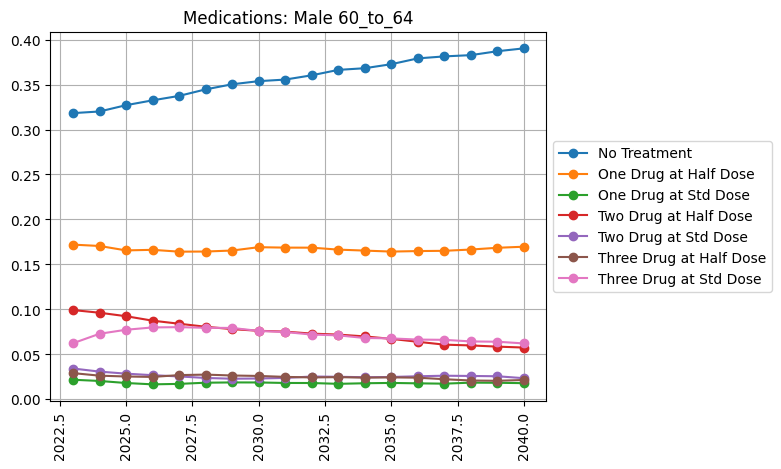

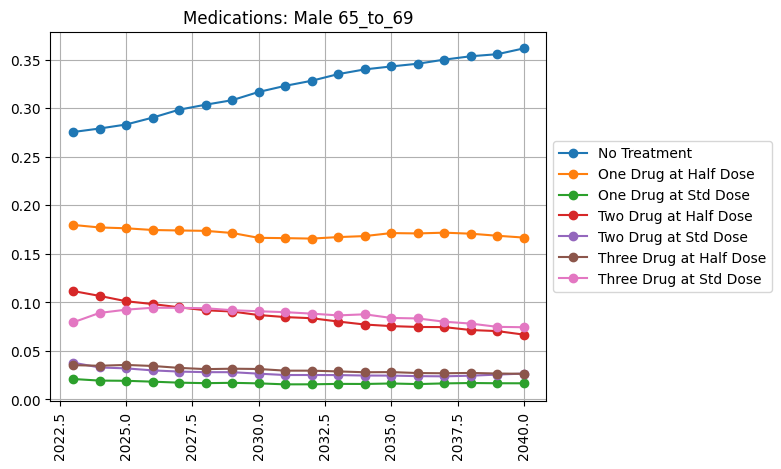

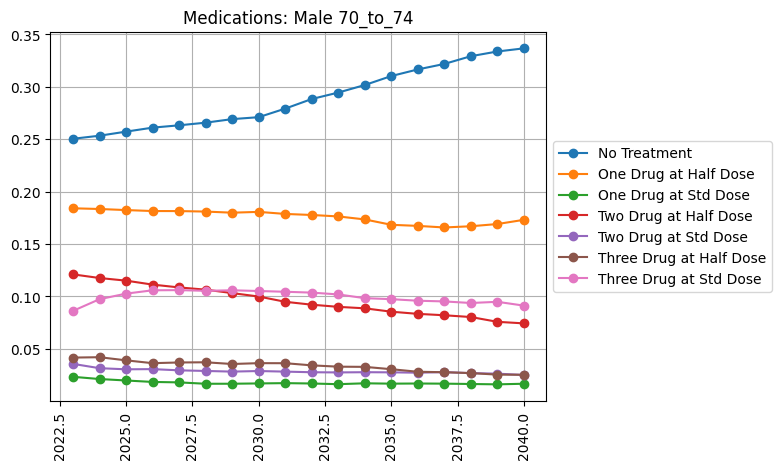

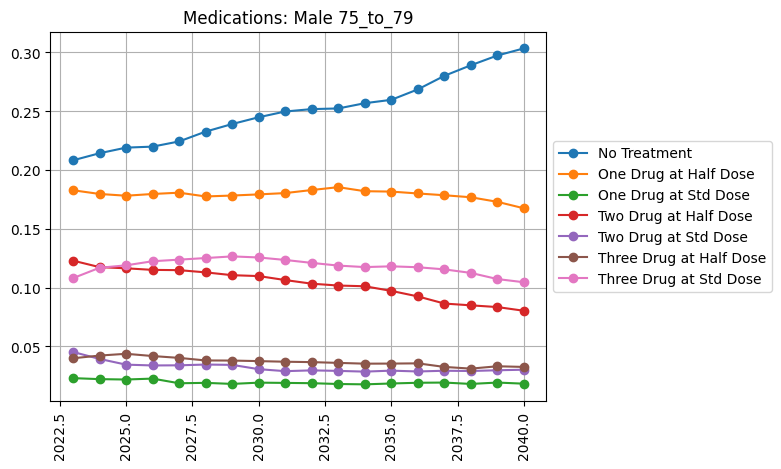

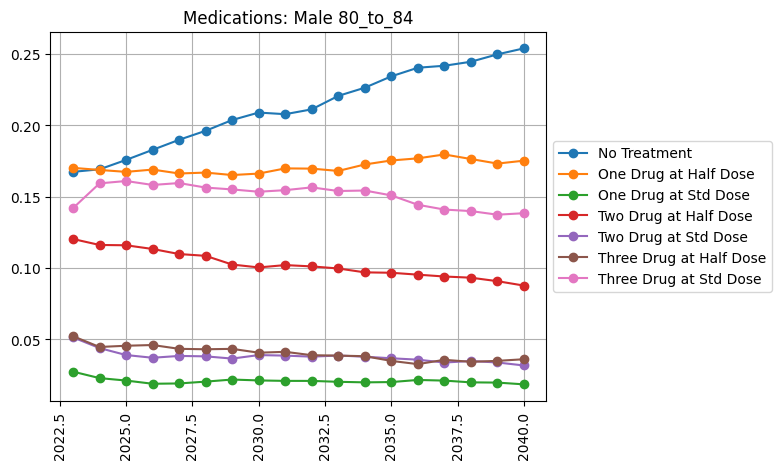

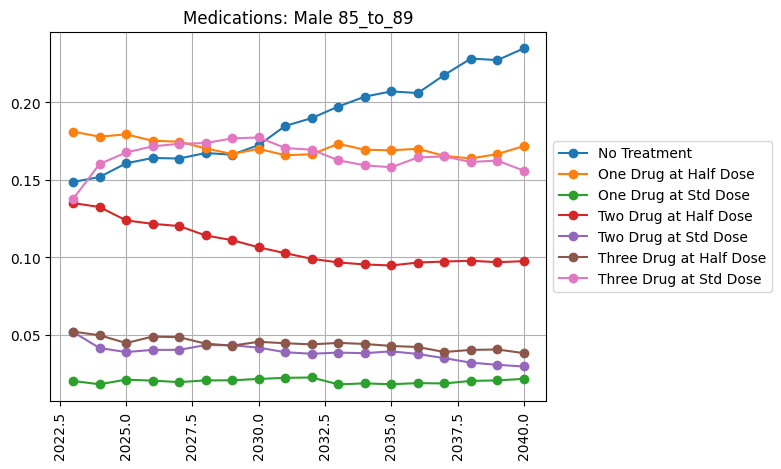

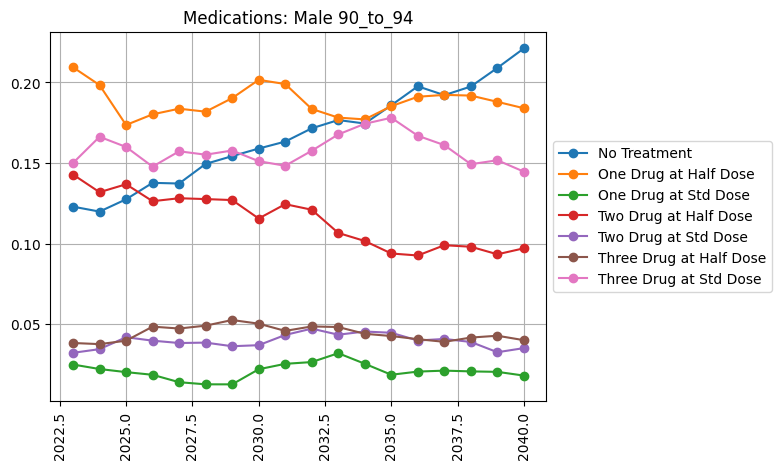

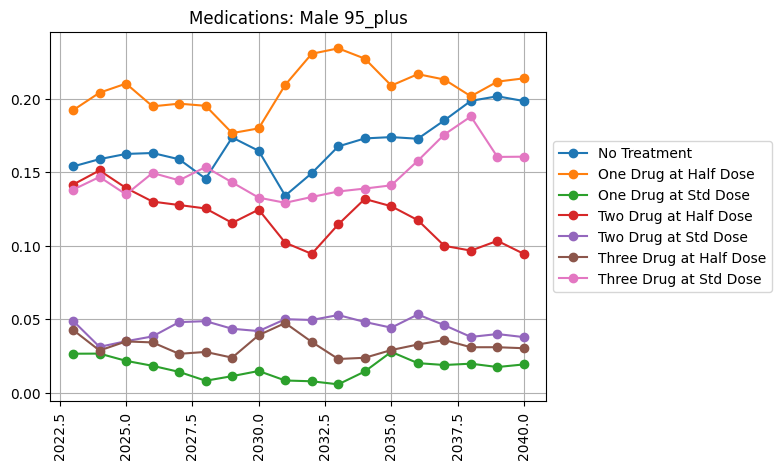

In [24]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='one_drug_half_dose_efficacy')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='one_drug_std_dose_efficacy')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='two_drug_half_dose_efficacy')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='two_drug_std_dose_efficacy')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='three_drug_half_dose_efficacy')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        three_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='three_drug_std_dose_efficacy')]
        plt.plot(three_std['year'], three_std['mean'], marker='o')
        plt.title(f'Medications: {sex} {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', 'One Drug at Half Dose','One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose','Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()

### LDL-C Meds

In [ ]:
ldl_meds = pd.read_csv(sim_results_dir + '/ldlc_medication_person_time.csv')
ldl_meds.head()

In [ ]:
meds_adherent = ldl_meds.loc[(ldl_meds['medication_adherence']=='adherent') & (ldl_meds['scenario']=='baseline')].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['sex', 'age','year', 'ldlc_medication'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ.head()

In [ ]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_intensity')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='medium_intensity')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_intensity')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_med_with_eze')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_with_eze')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        plt.title(f'Medications: {sex} in {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment','Low Intensity','Medium Intensity','High Intensity','Low/Med Intensity with Eze','High Intensity with Eze'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()